In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import svm,metrics,tree,preprocessing,linear_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import Ridge,LinearRegression,LogisticRegression,ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor,BaggingClassifier,ExtraTreesClassifier
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


# Hiding the warnings
warnings.filterwarnings('ignore')

# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# Load dataset
# dataset = pd.read_csv('/content/drive/My Drive/DataCoSupplyChainDataset.csv')

dataset =pd.read_csv('/Users/yunbo/Documents/GitHub/PFL_Optimiozation/Data/DataCoSupplyChainDataset.csv', encoding='latin-1')
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
# print(dataset.head(30))


dataset['Customer Full Name'] = dataset['Customer Fname'].astype(str) + dataset['Customer Lname'].astype(str)
dataset['TotalPrice'] = dataset['Order Item Quantity'] * dataset[
    'Sales per customer']  # Multiplying item price * Order quantity



data = dataset.drop(
    ['Customer Email', 'Customer Id', 'Customer Password', 'Customer Fname', 'Customer Lname',
      'Product Description', 'Product Image', 'Order Zipcode','Product Status','Order Profit Per Order','Product Price'], axis=1)

data['Customer Zipcode'] = data['Customer Zipcode'].fillna(0)  # Filling NaN columns with zero



data['order_year'] = pd.DatetimeIndex(data['order date (DateOrders)']).year
data['order_month'] = pd.DatetimeIndex(data['order date (DateOrders)']).month
data['order_week_day'] = pd.DatetimeIndex(data['order date (DateOrders)']).day_name()
data['order_hour'] = pd.DatetimeIndex(data['order date (DateOrders)']).hour
# data['order_second'] = pd.DatetimeIndex(data['order date (DateOrders)'])

data['shipping_year'] = pd.DatetimeIndex(data['shipping date (DateOrders)']).year
data['shipping_month'] = pd.DatetimeIndex(data['shipping date (DateOrders)']).month
data['shipping_week_day'] = pd.DatetimeIndex(data['shipping date (DateOrders)']).day_name()
data['shipping_hour'] = pd.DatetimeIndex(data['shipping date (DateOrders)']).hour


label_data = data[['shipping_week_day','order_week_day','Customer Full Name','Type','Delivery Status','Category Name','Customer City','Customer Country','Customer Segment','Customer State','Customer Street','Department Name','Market','Order City','Order Country','Order State','Order Status','Product Name','Shipping Mode']]

data['index'] = data['Order Region']


# target=data['Sales']


# data=data.drop(columns=['shipping_week_day','order_week_day','Customer Full Name','Sales','Type','Delivery Status','Category Name','Customer City','Customer Country','Customer Segment','Customer State','Customer Street','Department Name','Market','Order City','Order Country','order date (DateOrders)','Order Region','Order State','Order Status','Product Name','shipping date (DateOrders)','Shipping Mode'])

target=data['Sales']

data=data.drop(columns=['shipping_week_day','order_week_day','Customer Full Name','Sales','Type','Delivery Status','Category Name','Customer City','Customer Country','Customer Segment','Customer State','Customer Street','Department Name','Market','Order City','Order Country','order date (DateOrders)','Order State','Order Status','Product Name','shipping date (DateOrders)','Shipping Mode','Order Region'])

# data=data.drop(columns=['Sales','order date (DateOrders)','shipping date (DateOrders)','Order Region'])


def Labelencoder_feature(x):
    le=LabelEncoder()
    x=le.fit_transform(x)
    return x

# Exclude datetime columns from label encoding
# datetime_columns = ['order date (DateOrders)', 'shipping date (DateOrders)']
# data_encoded = data.drop(datetime_columns, axis=1)

# Apply label encoding to remaining columns
data_encoded = label_data.apply(Labelencoder_feature)

data = pd.concat([data_encoded, data], axis=1)

# # Calculate correlation matrix
# correlation_matrix = data.corr()


# Create heatmap
# plt.figure(figsize=(100, 50))
# sns.heatmap(correlation_matrix, annot=True, fmt=".3f", cmap="BuPu")
# plt.show()


# #Feature Selection based on importance
# from sklearn.feature_selection import f_regression
# F_values, p_values  = f_regression(data, target)

# import itertools
# f_reg_results = [(i, v, z) for i, v, z in itertools.zip_longest(data.columns, F_values,  ['%.3f' % p for p in p_values])]
# f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])

# f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])
# f_reg_results = f_reg_results.sort_values(by=['P_Value'])
# f_reg_results.P_Value= f_reg_results.P_Value.astype(float)
# f_reg_results=f_reg_results[f_reg_results.P_Value<0.06]
# print(f_reg_results)

# f_reg_list=f_reg_results.Variable.values
# print(f_reg_list)

# data_final=data[['Sales per customer','Order Id', 'Order Customer Id', 'Order Item Id',
#  'Order Item Product Price' ,'Department Id', 'Order Item Quantity',
#  'Category Id' ,'shipping_month' ,'Benefit per order' ,'Order Item Total',
#  'Product Card Id', 'Product Name', 'Order Item Cardprod Id' ,
#  'Order State', 'Product Category Id', 'order_week_day', 'shipping_year',
#  'Category Name', 'order_month', 'order_year' ,'Order Item Discount',
#  'Department Name', 'Market', 'TotalPrice', 'Order City',
#  'Days for shipment (scheduled)' ,'Customer Segment', 'Customer Full Name','index']]

print(data.shape)
data

(180519, 49)


,shipping_week_day,order_week_day,Customer Full Name,Type,Delivery Status,Category Name,Customer City,Customer Country,Customer Segment,Customer State,...,Product Card Id,Product Category Id,TotalPrice,order_year,order_month,order_hour,shipping_year,shipping_month,shipping_hour,index
0,2,6,1876,1,0,40,66,1,0,36,...,1360,73,314.640015,2018,1,22,2018,2,22,Southeast Asia
1,4,2,5378,3,1,40,66,1,0,36,...,1360,73,311.359985,2018,1,12,2018,1,12,South Asia
2,6,2,4429,0,3,40,452,0,0,5,...,1360,73,309.720001,2018,1,12,2018,1,12,South Asia
3,5,2,12929,1,0,40,285,0,2,5,...,1360,73,304.809998,2018,1,11,2018,1,11,Oceania
4,1,2,10638,2,0,40,66,1,1,36,...,1360,73,298.250000,2018,1,11,2018,1,11,Oceania
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,6,2,8426,0,3,18,59,0,2,31,...,1004,45,399.980011,2016,1,3,2016,1,3,Eastern Asia
180515,5,2,11679,1,1,18,26,0,1,5,...,1004,45,395.980011,2016,1,1,2016,1,1,Eastern Asia
180516,6,0,6300,3,1,18,55,0,1,7,...,1004,45,391.980011,2016,1,21,2016,1,21,Oceania
180517,1,0,9384,2,0,18,66,1,0,36,...,1004,45,387.980011,2016,1,20,2016,1,20,Oceania


In [6]:
# List to store the split dataframes
split_dataframes = []
data_final = data
# Iterate over each unique region
for region in data_final['index'].unique():
    # Filter data for the current region
    region_data = data_final[data_final['index'] == region]
    
    # Perform train-test split for the current region's data
    xs_region = region_data.loc[:, region_data.columns != 'Sales']
    ys_region = target[data_final['index'] == region]
    xs_train_region, xs_test_region, ys_train_region, ys_test_region = train_test_split(xs_region, ys_region, test_size=0.3, random_state=42)
    
    # Concatenate the features and target variables for train and test sets
    train_data_region = pd.concat([xs_train_region, ys_train_region], axis=1)
    test_data_region = pd.concat([xs_test_region, ys_test_region], axis=1)
    
    # Add region identifier
    train_data_region['index'] = region
    test_data_region['index'] = region
    
    # Append the split dataframes to the list
    split_dataframes.append(train_data_region)
    split_dataframes.append(test_data_region)

# Concatenate all split dataframes into a single dataframe
final_df = pd.concat(split_dataframes)

# Save the final dataframe to a CSV file
final_df.to_csv('integrated_train_test_data_by_region.csv', index=False)


In [7]:
import pandas as pd
import h5py

import pandas as pd

# Read the integrated_train_data.csv file
dataset = pd.read_csv('/Users/yunbo/Documents/GitHub/PFL_Optimiozation/FL_Clustering/integrated_train_data_ISMM.csv',encoding='latin-1')

# Get unique market values
markets = dataset['index'].unique()

# Create a dictionary to map regions to numbers
region_mapping = {region: i for i, region in enumerate(markets)}

# Add a new column 'Region Index' to represent the regions with numbers
dataset['Region Index'] = dataset['index'].map(region_mapping)

dataset = dataset.drop(columns=['index'])

# Print the modified dataset
print(dataset)
print(region_mapping)

# Get unique market values
markets = dataset['Region Index'].unique()

print(markets)

#
with h5py.File('market_data_test.h5', 'w') as f:
    for market in markets:
        market_str = str(market)
        market_data = dataset[dataset['Region Index'] == market]
        print(market_str)
        print(market_data)
        # Store the data as a dataset
        f.create_dataset(market_str, data=market_data.to_numpy())
        # Store the column names as an attribute
        f[market_str].attrs['columns'] = market_data.columns.tolist()

        Sales per customer  Order Id  Order Customer Id  Order Item Id  \
0               314.640015     77202              20755         180517   
1               311.359985     75939              19492         179254   
2               309.720001     75938              19491         179253   
3               304.809998     75937              19490         179252   
4               298.250000     75936              19489         179251   
...                    ...       ...                ...            ...   
180514          399.980011     26043               1005          65177   
180515          395.980011     26037               9141          65161   
180516          391.980011     26024                291          65129   
180517          387.980011     26022               2813          65126   
180518          383.980011     26018               7547          65113   

        Order Item Product Price  Department Id  Order Item Quantity  \
0                     327.750000       

              0        1        2         3           4    5    6     7    8   \
0     314.640015  77202.0  20755.0  180517.0  327.750000  2.0  1.0  73.0  2.0   
1     268.760010  75929.0  19482.0  179244.0  327.750000  2.0  1.0  73.0  1.0   
2     262.200012  75928.0  19481.0  179243.0  327.750000  2.0  1.0  73.0  1.0   
3     317.920013  75905.0  19458.0  179220.0  327.750000  2.0  1.0  73.0  1.0   
4     298.250000  75900.0  19453.0  179215.0  327.750000  2.0  1.0  73.0  1.0   
...          ...      ...      ...       ...         ...  ...  ...   ...  ...   
9534  395.980011  26165.0   6024.0   65495.0  399.980011  7.0  1.0  45.0  1.0   
9535  347.980011  26130.0   5187.0   65409.0  399.980011  7.0  1.0  45.0  1.0   
9536  391.980011  26087.0   2642.0   65296.0  399.980011  7.0  1.0  45.0  1.0   
9537  387.980011  26083.0   1238.0   65285.0  399.980011  7.0  1.0  45.0  1.0   
9538  347.980011  26059.0   8247.0   65219.0  399.980011  7.0  1.0  45.0  1.0   

              9   ...      

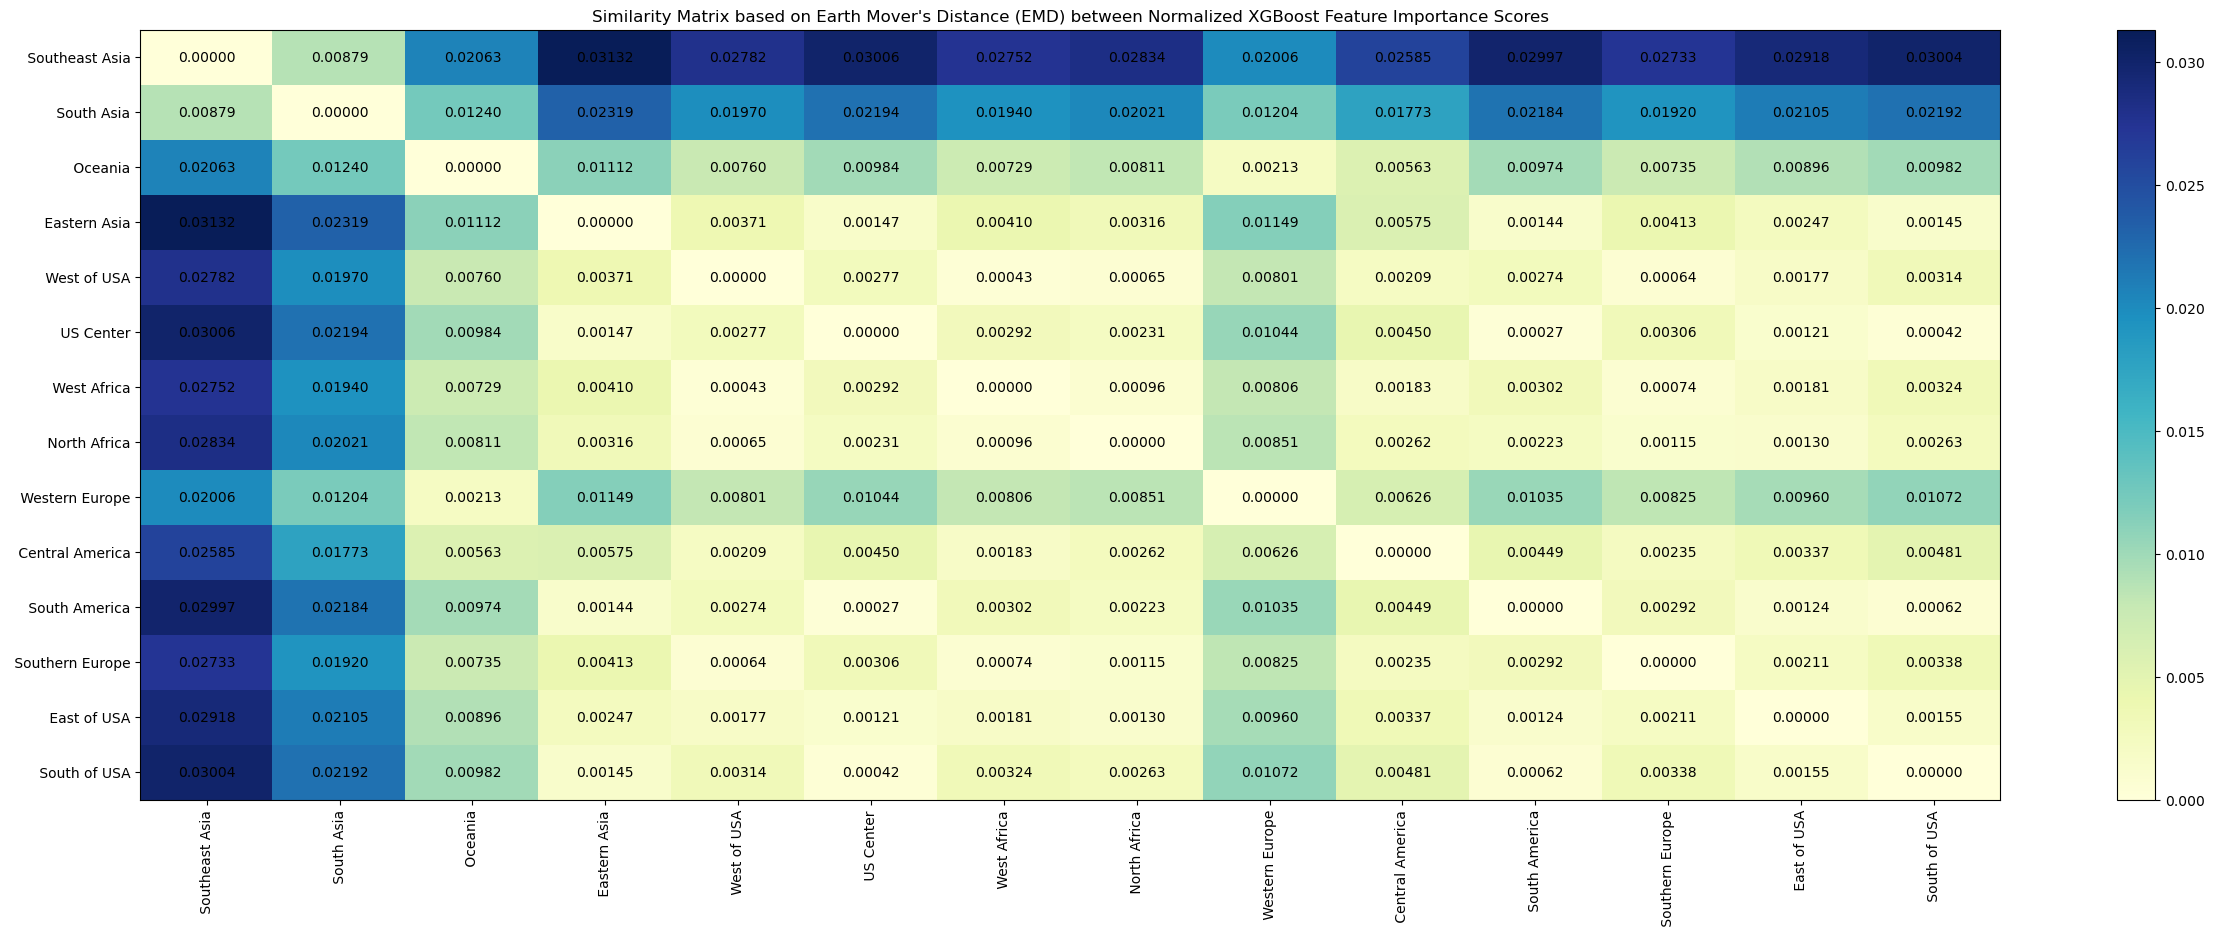

In [14]:
import pandas as pd
import networkx as nx
from sklearn.metrics import jaccard_score
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from grakel.kernels import GraphletSampling
from grakel.utils import graph_from_networkx
from sklearn.cluster import AgglomerativeClustering
import h5py
import xgboost as xgb
from scipy.stats import wasserstein_distance

# Step i: Reading Data and XGBoost Feature Importance

# Open the HDF5 file
file = h5py.File("market_data_test.h5", "r")

region_map = {
    0: "Southeast Asia",
    1: "South Asia",
    2: "Oceania",
    3: "Eastern Asia",
    4: "West Asia",
    5: "West of USA",
    6: "US Center",
    7: "West Africa",
    8: "Central Africa",
    9: "North Africa",
    10: "Western Europe",
    11: "Northern Europe",
    12: "Central America",
    13: "Caribbean",
    14: "South America",
    15: "East Africa",
    16: "Southern Europe",
    17: "East of USA",
    18: "Canada",
    19: "Southern Africa",
    20: "Central Asia",
    21: "Eastern Europe",
    22: "South of USA",
}

sheet_names = ['0', '1', '2', '3', '5', '6', '7', '9', '10', '12', '14', '16', '17', '22']

# Initialize an empty list to store DataFrames from each sheet
dataframes = []

# Read and concatenate DataFrames from each sheet
for sheet_name in sheet_names:
    # Read the dataset using the current sheet name
    dataset = file[sheet_name][:]
    dataset = pd.DataFrame(dataset)

    print(dataset)

    # Read the column names from the attributes
    column_names = file[sheet_name].attrs["columns"]

    # Assign column names to the dataset
    dataset.columns = column_names

    # Append the DataFrame to the list
    dataframes.append(dataset)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

# Replace "Region Index" with "Order Region"
df.rename(columns={"Region Index": "Order Region"}, inplace=True)

# Replace numbers with corresponding names using region_map
df["Order Region"] = df["Order Region"].map(region_map)


# Function to calculate EMD between two distributions
def calculate_emd(distribution1, distribution2):
    return wasserstein_distance(distribution1, distribution2)

# List to store XGBoost feature importance scores for each region
feature_importance_scores = []
# Copy the original DataFrame to avoid modifying the original data
df_cluster = df.copy()

for region in df_cluster['Order Region'].unique():
    # Create subset DataFrame for the current Order Region
    subset_df = df_cluster[df_cluster['Order Region'] == region].drop(columns=['Order Region'])

    y = subset_df['Sales'].values

    X = subset_df.drop(columns=['Sales']).values

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X, y)

    # Store feature importance scores
    feature_importance_scores.append(model.feature_importances_)

feature_importance_scores = np.array(feature_importance_scores)
print(feature_importance_scores)

num_regions = len(feature_importance_scores)

similarity_matrix_xgboost = np.zeros((num_regions, num_regions))


# Reverse the label encoding to get the original region names
reverse_mapping = {v: k for k, v in region_map.items()}
# List to store region names
region_names = []
# Create t-SNE projections and store region names
# Create t-SNE projections and store region names
for i, region in enumerate(df_cluster['Order Region'].unique()):
    region_names.append(region_map.get(region, f' {region}'))




# Function to normalize feature importance scores
def normalize_feature_importance(feature_importance_scores):
    max_scores = np.max(feature_importance_scores, axis=1)
    normalized_scores = feature_importance_scores / max_scores[:, np.newaxis]
    return normalized_scores

# Normalize feature importance scores
normalized_feature_importance = normalize_feature_importance(feature_importance_scores)

# Calculate similarity matrix using Earth Mover's Distance
for i in range(num_regions):
    for j in range(i + 1, num_regions):
        emd_value = calculate_emd(normalized_feature_importance[i], normalized_feature_importance[j])
        similarity_matrix_xgboost[i, j] = emd_value
        similarity_matrix_xgboost[j, i] = emd_value

# Plot the similarity matrix
plt.figure(figsize=(30, 10))
plt.imshow(similarity_matrix_xgboost, cmap="YlGnBu", interpolation='nearest', aspect='auto')

# Add text annotations for each grid
for i in range(len(region_names)):
    for j in range(len(region_names)):
        plt.text(j, i, f'{similarity_matrix_xgboost[i, j]:.5f}', ha='center', va='center', color='black')

plt.colorbar()
plt.title('Similarity Matrix based on Earth Mover\'s Distance (EMD) between Normalized XGBoost Feature Importance Scores')
plt.xticks(np.arange(len(region_names)), region_names, rotation=90)
plt.yticks(np.arange(len(region_names)), region_names)
plt.show()



In [9]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans

# Normalize feature importance scores
normalized_feature_importance = normalize_feature_importance(feature_importance_scores)

# Calculate pairwise EMD distances
emd_distances = pairwise_distances(normalized_feature_importance, metric=calculate_emd)

# Perform clustering using KMeans with EMD distances
num_clusters = 6  # Set the number of clusters as desired
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(emd_distances)

# Print cluster labels for each region
for region, label in zip(region_names, cluster_labels):
    print(f"Region: {region}, Cluster: {label}")


Region:  Southeast Asia, Cluster: 1
Region:  South Asia, Cluster: 2
Region:  Oceania, Cluster: 3
Region:  Eastern Asia, Cluster: 4
Region:  West of USA, Cluster: 0
Region:  US Center, Cluster: 4
Region:  West Africa, Cluster: 0
Region:  North Africa, Cluster: 0
Region:  Western Europe, Cluster: 3
Region:  Central America, Cluster: 5
Region:  South America, Cluster: 4
Region:  Southern Europe, Cluster: 0
Region:  East of USA, Cluster: 4
Region:  South of USA, Cluster: 4


Region:  Southeast Asia, Cluster: 9
Region:  South Asia, Cluster: 10
Region:  Oceania, Cluster: 1
Region:  Eastern Asia, Cluster: 4
Region:  West of USA, Cluster: 6
Region:  US Center, Cluster: 3
Region:  West Africa, Cluster: 6
Region:  North Africa, Cluster: 7
Region:  Western Europe, Cluster: 2
Region:  Central America, Cluster: 8
Region:  South America, Cluster: 3
Region:  Southern Europe, Cluster: 6
Region:  East of USA, Cluster: 5
Region:  South of USA, Cluster: 3


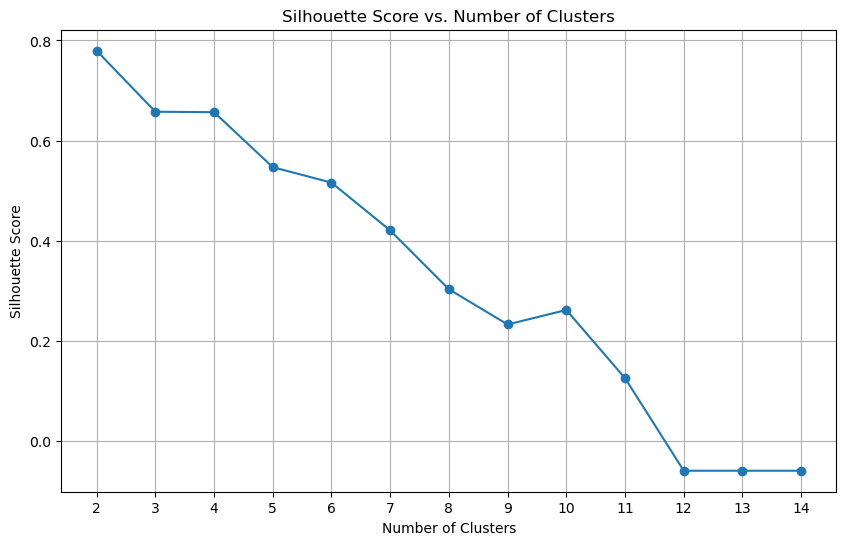

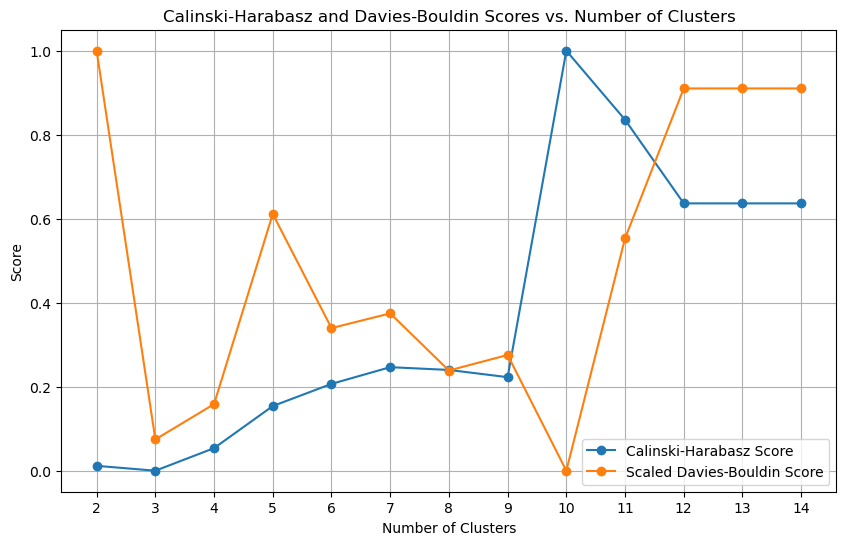

In [12]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans

# Function to add Laplace noise to data
def add_laplace_noise_to_matrix(matrix, sensitivity, epsilon):
    # Calculate scale parameter based on sensitivity and epsilon
    scale = sensitivity / epsilon
    # Generate Laplace noise matrix
    noise_matrix = np.random.laplace(loc=0.0, scale=scale, size=matrix.shape)
    # Add noise to the original matrix
    return matrix + noise_matrix

# Assuming feature_importance_scores is your original data
# Define sensitivity of the feature importance scores
# Sensitivity depends on the data domain and the normalization method used
# For simplicity, let's assume a sensitivity of 1
sensitivity = 0.01

# Define privacy parameter epsilon for adding noise to feature importance scores
epsilon_feature_importance = 5  # You can adjust this parameter based on desired privacy level

# Add Laplace noise to the feature importance scores
normalized_feature_importance_noisy = add_laplace_noise_to_matrix(normalized_feature_importance, sensitivity, epsilon_feature_importance)

# Calculate pairwise EMD distances with noisy feature importance scores
emd_distances_noisy = pairwise_distances(normalized_feature_importance_noisy, metric=calculate_emd)


# Calculate linkage matrix using noisy EMD distances
linkage_matrix = linkage(emd_distances_noisy, method='average')  # You can adjust the method as desired

# Perform agglomerative clustering
num_clusters = 10  # Set the number of clusters as desired
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Print cluster labels for each region
for region, label in zip(region_names, cluster_labels):
    print(f"Region: {region}, Cluster: {label}")



from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Initialize lists to store silhouette scores and other metrics
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

# Range of number of clusters to evaluate
num_clusters_range = range(2, 15)

for num_clusters in num_clusters_range:
    # Perform agglomerative clustering
    cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    
    # Calculate silhouette score
    silhouette = silhouette_score(emd_distances, cluster_labels)
    silhouette_scores.append(silhouette)
    
    # Calculate Calinski-Harabasz score
    ch_score = calinski_harabasz_score(emd_distances, cluster_labels)
    calinski_harabasz_scores.append(ch_score)
    
    # Calculate Davies-Bouldin score
    db_score = davies_bouldin_score(emd_distances, cluster_labels)
    davies_bouldin_scores.append(db_score)

# Plotting silhouette score
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(num_clusters_range)
plt.grid(True)
plt.show()

# Scale Davies-Bouldin scores
scaler = MinMaxScaler()
davies_bouldin_scores_scaled = scaler.fit_transform(np.array(davies_bouldin_scores).reshape(-1, 1)).flatten()
calinski_harabasz_scores = scaler.fit_transform(np.array(calinski_harabasz_scores).reshape(-1, 1)).flatten()

# Plotting both evaluation metrics
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, calinski_harabasz_scores, marker='o', label='Calinski-Harabasz Score')
plt.plot(num_clusters_range, davies_bouldin_scores_scaled, marker='o', label='Scaled Davies-Bouldin Score')
plt.title('Calinski-Harabasz and Davies-Bouldin Scores vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.xticks(num_clusters_range)
plt.legend()
plt.grid(True)
plt.show()


           0        1         2           3    4     5    6           7   \
0     77202.0  20755.0  180517.0  327.750000  2.0  73.0  2.0   91.250000   
1     75929.0  19482.0  179244.0  327.750000  2.0  73.0  1.0   45.689999   
2     75928.0  19481.0  179243.0  327.750000  2.0  73.0  1.0   21.760000   
3     75905.0  19458.0  179220.0  327.750000  2.0  73.0  1.0  152.600006   
4     75900.0  19453.0  179215.0  327.750000  2.0  73.0  1.0  143.160004   
...       ...      ...       ...         ...  ...   ...  ...         ...   
9534  26165.0   6024.0   65495.0  399.980011  7.0  45.0  1.0  133.839996   
9535  26130.0   5187.0   65409.0  399.980011  7.0  45.0  1.0  130.490005   
9536  26087.0   2642.0   65296.0  399.980011  7.0  45.0  1.0 -337.100006   
9537  26083.0   1238.0   65285.0  399.980011  7.0  45.0  1.0 -258.779999   
9538  26059.0   8247.0   65219.0  399.980011  7.0  45.0  1.0   50.110001   

          8     9   ...      17         18   19   20      21   22   23  \
0     1360.0 

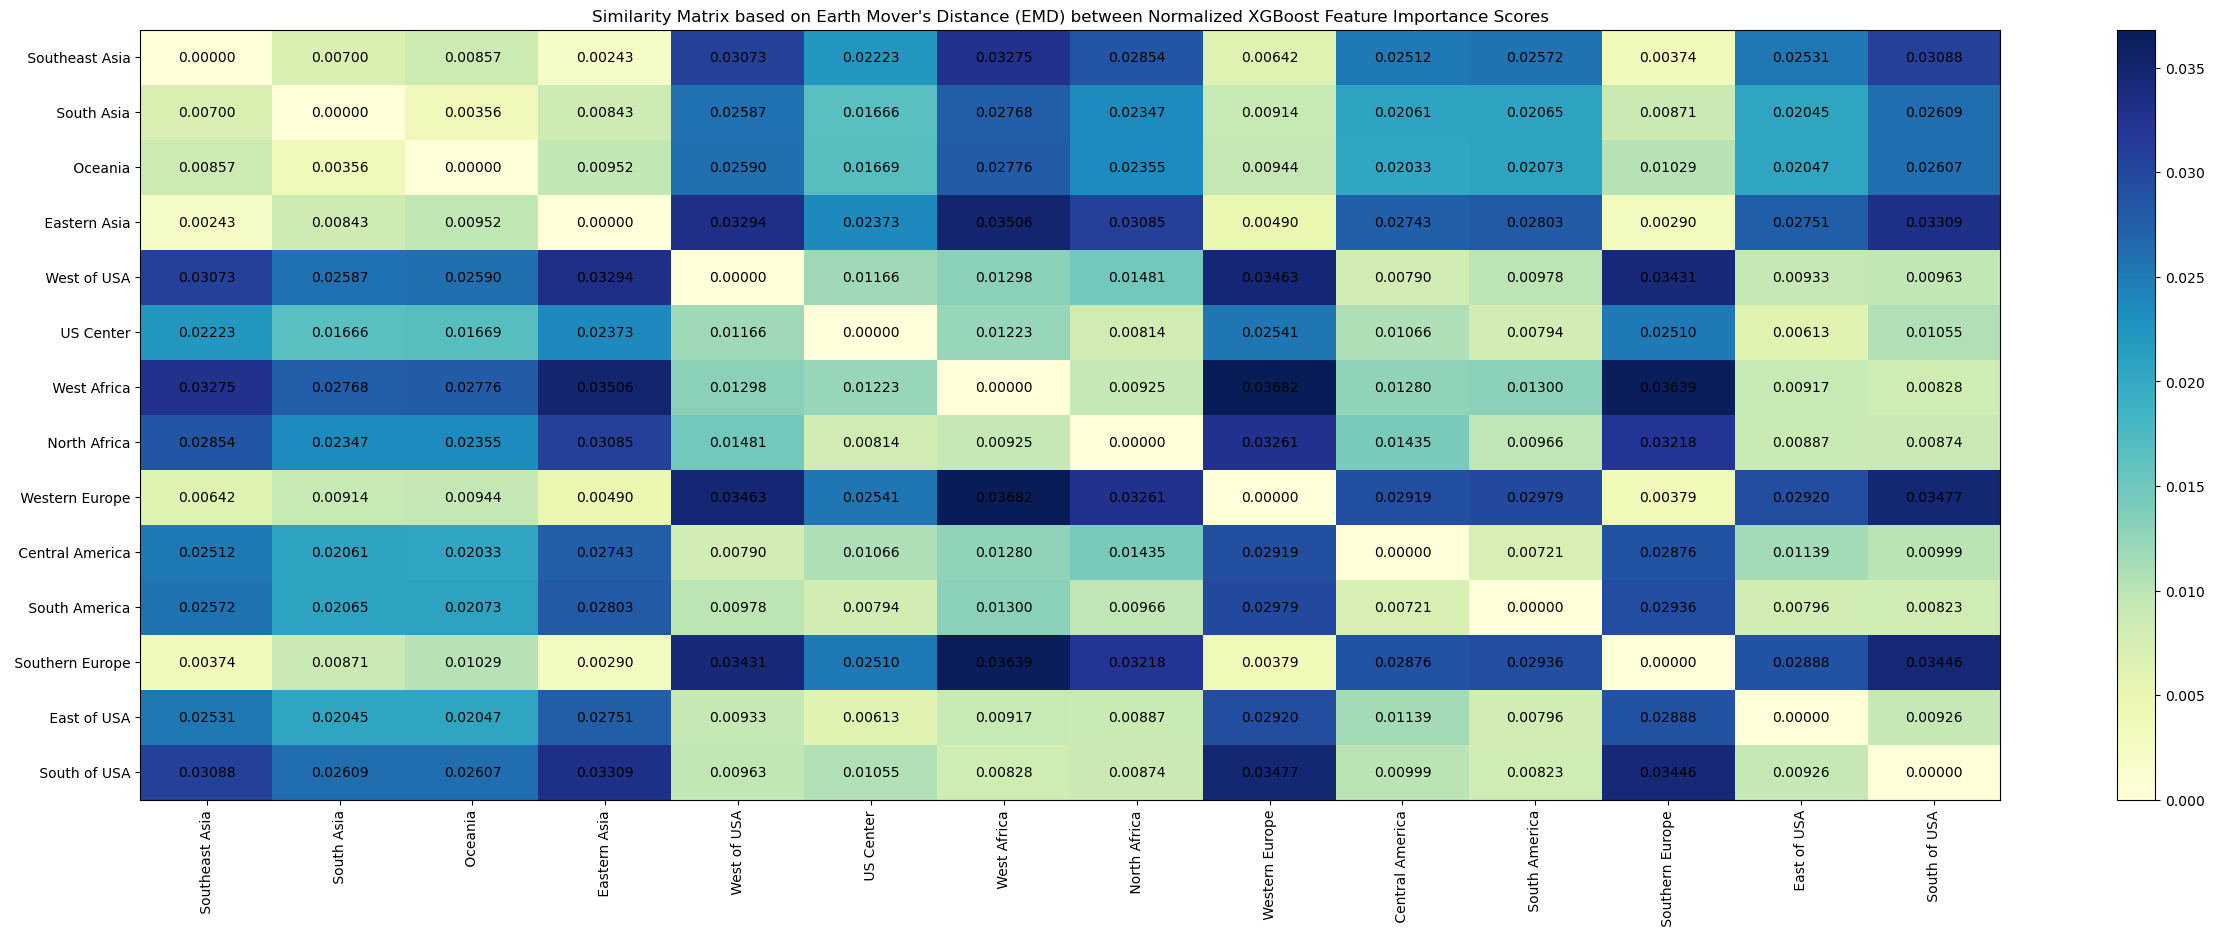

In [15]:
import pandas as pd
import networkx as nx
from sklearn.metrics import jaccard_score
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from grakel.kernels import GraphletSampling
from grakel.utils import graph_from_networkx
from sklearn.cluster import AgglomerativeClustering
import h5py
import xgboost as xgb
from scipy.stats import wasserstein_distance

# Step i: Reading Data and XGBoost Feature Importance

# Open the HDF5 file
file = h5py.File("market_data.h5", "r")

region_map = {
    0: "Southeast Asia",
    1: "South Asia",
    2: "Oceania",
    3: "Eastern Asia",
    4: "West Asia",
    5: "West of USA",
    6: "US Center",
    7: "West Africa",
    8: "Central Africa",
    9: "North Africa",
    10: "Western Europe",
    11: "Northern Europe",
    12: "Central America",
    13: "Caribbean",
    14: "South America",
    15: "East Africa",
    16: "Southern Europe",
    17: "East of USA",
    18: "Canada",
    19: "Southern Africa",
    20: "Central Asia",
    21: "Eastern Europe",
    22: "South of USA",
}

sheet_names = ['0', '1', '2', '3', '5', '6', '7', '9', '10', '12', '14', '16', '17', '22']

# Initialize an empty list to store DataFrames from each sheet
dataframes = []

# Read and concatenate DataFrames from each sheet
for sheet_name in sheet_names:
    # Read the dataset using the current sheet name
    dataset = file[sheet_name][:]
    dataset = pd.DataFrame(dataset)

    print(dataset)

    # Read the column names from the attributes
    column_names = file[sheet_name].attrs["columns"]

    # Assign column names to the dataset
    dataset.columns = column_names

    # Append the DataFrame to the list
    dataframes.append(dataset)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

# Replace "Region Index" with "Order Region"
df.rename(columns={"Region Index": "Order Region"}, inplace=True)

# Replace numbers with corresponding names using region_map
df["Order Region"] = df["Order Region"].map(region_map)


# Function to calculate EMD between two distributions
def calculate_emd(distribution1, distribution2):
    return wasserstein_distance(distribution1, distribution2)

# List to store XGBoost feature importance scores for each region
feature_importance_scores = []
# Copy the original DataFrame to avoid modifying the original data
df_cluster = df.copy()

for region in df_cluster['Order Region'].unique():
    # Create subset DataFrame for the current Order Region
    subset_df = df_cluster[df_cluster['Order Region'] == region].drop(columns=['Order Region'])

    y = subset_df['Sales'].values

    X = subset_df.drop(columns=['Sales']).values

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X, y)

    # Store feature importance scores
    feature_importance_scores.append(model.feature_importances_)

feature_importance_scores = np.array(feature_importance_scores)
print(feature_importance_scores)

num_regions = len(feature_importance_scores)

similarity_matrix_xgboost = np.zeros((num_regions, num_regions))


# Reverse the label encoding to get the original region names
reverse_mapping = {v: k for k, v in region_map.items()}
# List to store region names
region_names = []
# Create t-SNE projections and store region names
# Create t-SNE projections and store region names
for i, region in enumerate(df_cluster['Order Region'].unique()):
    region_names.append(region_map.get(region, f' {region}'))




# Function to normalize feature importance scores
def normalize_feature_importance(feature_importance_scores):
    max_scores = np.max(feature_importance_scores, axis=1)
    normalized_scores = feature_importance_scores / max_scores[:, np.newaxis]
    return normalized_scores

# Normalize feature importance scores
normalized_feature_importance = normalize_feature_importance(feature_importance_scores)

# Calculate similarity matrix using Earth Mover's Distance
for i in range(num_regions):
    for j in range(i + 1, num_regions):
        emd_value = calculate_emd(normalized_feature_importance[i], normalized_feature_importance[j])
        similarity_matrix_xgboost[i, j] = emd_value
        similarity_matrix_xgboost[j, i] = emd_value

# Plot the similarity matrix
plt.figure(figsize=(30, 10))
plt.imshow(similarity_matrix_xgboost, cmap="YlGnBu", interpolation='nearest', aspect='auto')

# Add text annotations for each grid
for i in range(len(region_names)):
    for j in range(len(region_names)):
        plt.text(j, i, f'{similarity_matrix_xgboost[i, j]:.5f}', ha='center', va='center', color='black')

plt.colorbar()
plt.title('Similarity Matrix based on Earth Mover\'s Distance (EMD) between Normalized XGBoost Feature Importance Scores')
plt.xticks(np.arange(len(region_names)), region_names, rotation=90)
plt.yticks(np.arange(len(region_names)), region_names)
plt.show()



In [23]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans

# Normalize feature importance scores
normalized_feature_importance = normalize_feature_importance(feature_importance_scores)

# Calculate pairwise EMD distances
emd_distances = pairwise_distances(normalized_feature_importance, metric=calculate_emd)

# Perform clustering using KMeans with EMD distances
num_clusters = 3  # Set the number of clusters as desired
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(emd_distances)

# Print cluster labels for each region
for region, label in zip(region_names, cluster_labels):
    print(f"Region: {region}, Cluster: {label}")


Region:  Southeast Asia, Cluster: 1
Region:  South Asia, Cluster: 2
Region:  Oceania, Cluster: 2
Region:  Eastern Asia, Cluster: 1
Region:  West of USA, Cluster: 0
Region:  US Center, Cluster: 0
Region:  West Africa, Cluster: 0
Region:  North Africa, Cluster: 0
Region:  Western Europe, Cluster: 1
Region:  Central America, Cluster: 0
Region:  South America, Cluster: 0
Region:  Southern Europe, Cluster: 1
Region:  East of USA, Cluster: 0
Region:  South of USA, Cluster: 0
